CHRISTIAN CAMILO GARZON VASQUEZ


---


FUNDAMENTOS DE DEEP LEARNING

FACULTAD DE INGENIERIA

UNIVERSIDAD DE ANTIOQUIA


---




#**SIMPLE RNN**
#**Y**
#**LSTM**

**BASADO EN:** https://ai-leader.com/2020/05/09/using-lstm-with-1d-2d-and-3d-array/, https://medium.com/machine-learning-algorithms/mnist-using-recurrent-neural-network-2d070a5915a2 Y NOTAS DE CLASE

# 0. LIBRERIAS REQUERIDAS

In [51]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM, Dropout, SimpleRNN
import matplotlib as mpl
from matplotlib import pylab as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. CARGA DE DATOS Y ANÁLISIS INICIAL

In [3]:
#Montaje y visualización de las primeras 5 muestras
#Asegurate de tener el archivo "data_bin_balanceada.csv" en la misma carpeta
df = pd.read_csv('data_bin_balanceada.csv')
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53,30319,1,1,45,61,45,45,45.000000,0.000000,...,20,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,0
1,80,99185660,9,6,353,11595,353,0,39.222222,117.666667,...,32,5991.0,0.000000,5991,5991,99100000.0,0.000000e+00,99100000,99100000,1
2,443,33208779,20,17,2012,12206,517,0,100.600000,188.018868,...,32,581694.0,291640.535046,787915,375473,16022615.0,3.473294e+06,18478605,13566625,0
3,53,92872,2,2,70,270,35,35,35.000000,0.000000,...,32,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,0
4,48292,3,2,0,0,0,0,0,0.000000,0.000000,...,32,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,0


#2. DIVIDIENDO DATASET ENTRE CONJUNTOS DE ENTRENO, TESTEO Y VALIDACION


In [4]:
#Evitando valores NaN e inf  
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)] 

#Dimensiones base de datos
df.shape

(1113745, 79)

In [8]:
#Usando sklearn para dividir dataset cargado
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

#Tomando características y etiquetas de los arrays Form np arrays of labels and features
train_labels = np.array(train_df.pop(' Label')) #Tomando etiquetas de entrenamiento
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop(' Label')) #Tomando etiquetas de validacion
test_labels = np.array(test_df.pop(' Label')) #Tomando etiquetas de testeo

train_features = np.array(train_df) #Tomando caracteristícas de entrenamiento
val_features = np.array(val_df) #Tomando caracteristícas de validación
test_features = np.array(test_df) #Tomando caracteristícas de testeo

In [12]:
scaler = StandardScaler() #Normalizar datos
train_features = scaler.fit_transform(train_features) #Escalar datos de entrenamiento y aprender parámetros de escalado.

val_features = scaler.transform(val_features) #Se usa la misma media y varianza de entrenamiento para validación
test_features = scaler.transform(test_features) #Se usa la misma media y varianza de entrenamiento para testeo

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)
print("------------------------------------------")
print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (712796,)
Validation labels shape: (178200,)
Test labels shape: (222749,)
------------------------------------------
Training features shape: (712796, 78)
Validation features shape: (178200, 78)
Test features shape: (222749, 78)


#3. ENSAMBLAJE DE LOS MODELOS

In [30]:
#Hiperparámetros
units = 50
dropout = 0.2
num_labels = 2
BATCH_SIZE = 256
EPOCHS = 5

In [34]:
#Reshape necesario para procesamiento en RNN y LSTM. https://ai-leader.com/2020/05/09/using-lstm-with-1d-2d-and-3d-array/
train_features = np.reshape(train_features,(train_features.shape[0], train_features.shape[1], 1))
test_features = np.reshape(test_features,(test_features.shape[0], test_features.shape[1], 1))
print("TRAIN FEATURES SHAPE: ", train_features.shape)
print("TEST FEATURES SHAPE: ", test_features.shape)

TRAIN FEATURES SHAPE:  (712796, 78, 1)
TEST FEATURES SHAPE:  (222749, 78, 1)


In [33]:
#Configurando EARLY STOPPING
early_stopping = tf.keras.callbacks.EarlyStopping( #Aplicando early stopping evitando caer procesamiento inecesario
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [42]:
#Métricas a evaluar en el modelo
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

RNN

In [35]:
model_RNN = Sequential()
model_RNN.add(SimpleRNN(units=units, input_shape=[train_features.shape[1], 1])) #(79, 1)
model_RNN.add(Dropout(dropout))           
model_RNN.add(Dense(1, activation="sigmoid"))
model_RNN.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_RNN.compile(loss='mean_squared_error', optimizer='adam', metrics=METRICS)

LSTM


In [66]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(units=units, input_shape=[train_features.shape[1], 1])) #(79, 1)
model_LSTM.add(Dropout(dropout))           
model_LSTM.add(Dense(1, activation="sigmoid"))
model_LSTM.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [67]:
model_LSTM.compile(loss='mean_squared_error', optimizer='adam', metrics=METRICS)

# 4. ENTRENAMIENTO DE LOS MODELOS

RNN

In [48]:
baseline_history_RNN = model_RNN.fit(
    train_features,
    np.array(train_labels),
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/5
2785/2785 [==============================] - 168s 48ms/step - loss: 0.0217 - tp: 350964.0000 - fp: 12596.0000 - tn: 343703.0000 - fn: 5533.0000 - accuracy: 0.9746 - precision: 0.9654 - recall: 0.9845 - auc: 0.9923 - prc: 0.9914 - val_loss: 0.0183 - val_tp: 87934.0000 - val_fp: 3042.0000 - val_tn: 86393.0000 - val_fn: 831.0000 - val_accuracy: 0.9783 - val_precision: 0.9666 - val_recall: 0.9906 - val_auc: 0.9940 - val_prc: 0.9937
Epoch 2/5
2785/2785 [==============================] - 136s 49ms/step - loss: 0.0202 - tp: 351401.0000 - fp: 11718.0000 - tn: 344581.0000 - fn: 5096.0000 - accuracy: 0.9764 - precision: 0.9677 - recall: 0.9857 - auc: 0.9930 - prc: 0.9925 - val_loss: 0.0160 - val_tp: 87787.0000 - val_fp: 2334.0000 - val_tn: 87101.0000 - val_fn: 978.0000 - val_accuracy: 0.9814 - val_precision: 0.9741 - val_recall: 0.9890 - val_auc: 0.9952 - val_prc: 0.9952
Epoch 3/5
2785/2785 [==============================] - 131s 47ms/step - loss: 0.0204 - tp: 351485.0000 - fp: 12007.0

LSTM

In [68]:
baseline_history_LSTM = model_LSTM.fit(
    train_features,
    np.array(train_labels),
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/5
2785/2785 [==============================] - 36s 12ms/step - loss: 0.0799 - tp: 399440.0000 - fp: 33939.0000 - tn: 411795.0000 - fn: 45822.0000 - accuracy: 0.9105 - precision: 0.9217 - recall: 0.8971 - auc: 0.9675 - prc: 0.9668 - val_loss: 0.0476 - val_tp: 86257.0000 - val_fp: 7745.0000 - val_tn: 81690.0000 - val_fn: 2508.0000 - val_accuracy: 0.9425 - val_precision: 0.9176 - val_recall: 0.9717 - val_auc: 0.9745 - val_prc: 0.9719
Epoch 2/5
2785/2785 [==============================] - 29s 11ms/step - loss: 0.0399 - tp: 342391.0000 - fp: 19993.0000 - tn: 336306.0000 - fn: 14106.0000 - accuracy: 0.9522 - precision: 0.9448 - recall: 0.9604 - auc: 0.9805 - prc: 0.9799 - val_loss: 0.0321 - val_tp: 86057.0000 - val_fp: 3988.0000 - val_tn: 85447.0000 - val_fn: 2708.0000 - val_accuracy: 0.9624 - val_precision: 0.9557 - val_recall: 0.9695 - val_auc: 0.9871 - val_prc: 0.9871
Epoch 3/5
2785/2785 [==============================] - 31s 11ms/step - loss: 0.0337 - tp: 344841.0000 - fp: 16772.

# 5. EVALUACION DE LOS MODELOS

In [72]:
#Graficando métricas
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

RNN

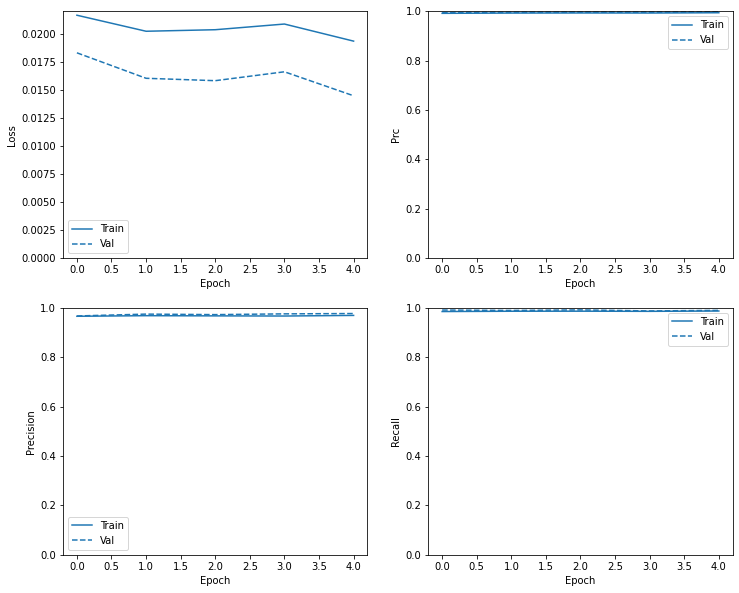

In [74]:
plot_metrics(baseline_history_RNN)

In [76]:
baseline_results_RNN = model_RNN.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model_RNN.metrics_names, baseline_results_RNN):
  print(name, ': ', value)
print()

loss :  0.014170554466545582
tp :  110077.0
fp :  2578.0
tn :  108877.0
fn :  1217.0
accuracy :  0.9829629063606262
precision :  0.9771159887313843
recall :  0.9890649914741516
auc :  0.9964742660522461
prc :  0.9966427683830261



LSTM

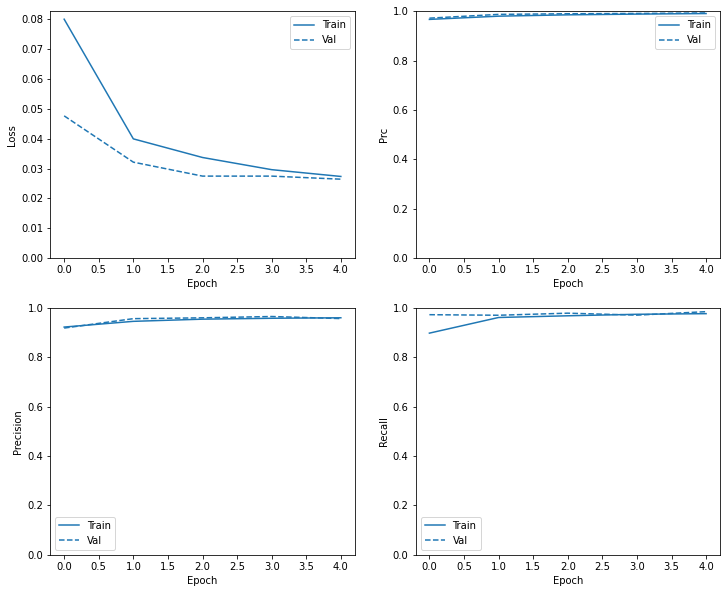

In [75]:
plot_metrics(baseline_history_LSTM)

In [77]:
baseline_results_LSTM = model_LSTM.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model_LSTM.metrics_names, baseline_results_LSTM):
  print(name, ': ', value)
print()

loss :  0.026138100773096085
tp :  109466.0
fp :  4895.0
tn :  106560.0
fn :  1828.0
accuracy :  0.9698180556297302
precision :  0.9571969509124756
recall :  0.9835750460624695
auc :  0.9927149415016174
prc :  0.9932591319084167



# 6. MATRICES DE CONFUSION

In [80]:
#Graficando matriz de confusión
def matriz_C(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

RNN

In [79]:
train_predictions_baseline_RNN = model_RNN.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline_RNN = model_RNN.predict(test_features, batch_size=BATCH_SIZE)

871/871 [==============================] - 9s 10ms/step


Legitimate Transactions Detected (True Negatives):  108877
Legitimate Transactions Incorrectly Detected (False Positives):  2578
Fraudulent Transactions Missed (False Negatives):  1217
Fraudulent Transactions Detected (True Positives):  110077
Total Fraudulent Transactions:  111294


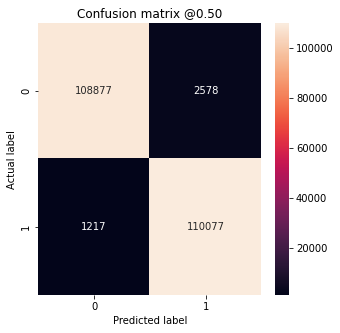

In [81]:
matriz_C(test_labels, test_predictions_baseline_RNN)

LSTM

In [82]:
train_predictions_baseline_LSTM = model_LSTM.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline_LSTM = model_LSTM.predict(test_features, batch_size=BATCH_SIZE)

871/871 [==============================] - 3s 4ms/step


Legitimate Transactions Detected (True Negatives):  106560
Legitimate Transactions Incorrectly Detected (False Positives):  4895
Fraudulent Transactions Missed (False Negatives):  1828
Fraudulent Transactions Detected (True Positives):  109466
Total Fraudulent Transactions:  111294


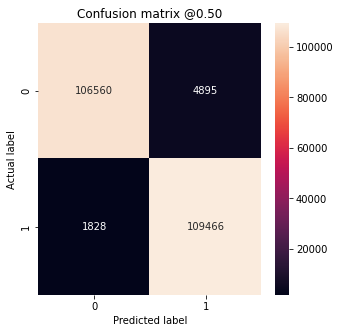

In [83]:
matriz_C(test_labels, test_predictions_baseline_LSTM)